In [1]:
from pprint import pprint
from tensorflow.keras.utils import plot_model
import numpy as np

---
## Test Network

In [2]:
from alphazero.models.network import Network

In [3]:
network = Network(31)

Metal device set to: Apple M1 Pro


2022-11-06 15:11:32.150134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-06 15:11:32.150282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
network.model.summary()

Model: "policy"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 496)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          127232      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 256)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout[0][0]']                
                                                                                             

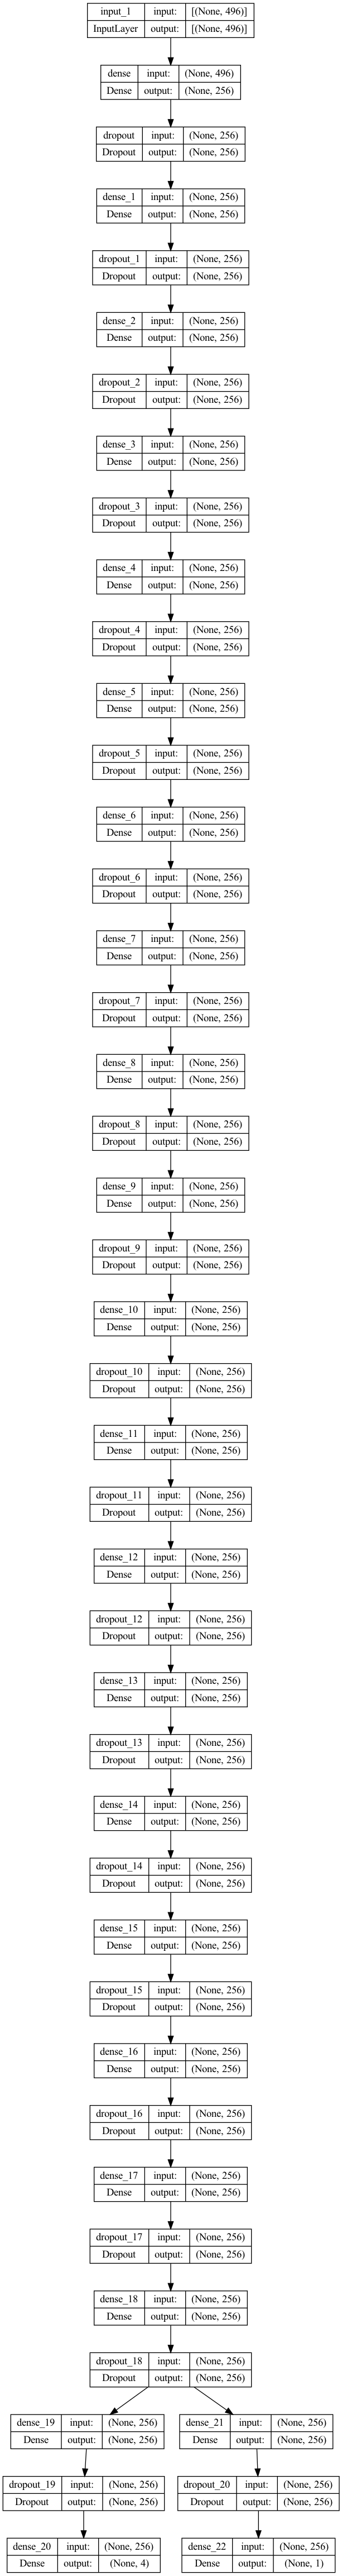

In [5]:
plot_model(network.model, show_shapes=True)

In [6]:
board = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 4], [4, 0, 4, 2]])

In [7]:
network_output = network.predictions(board)

In [8]:
pprint(network_output)

NetworkOutput(value=-0.032088544219732285, probabilities={0: 0.2517900360802107, 1: 0.26401188005871273, 2: 0.25651559956156345, 3: 0.22768248429951296})
